In [14]:
import torch
import matplotlib.pyplot as plt
from torch import optim, distributions, nn
from tqdm.notebook import tqdm
from gpzoo.gp import SVGP, VNNGP
from gpzoo.kernels import NSF_RBF, RBF
from gpzoo.likelihoods import GaussianLikelihood, NSF2
import squidpy as sq
import numpy as np
from gpzoo.utilities import train, deviancePoisson
import time
import scanpy as sc
import random


In [3]:
new_model=False

# Visium Data Preprocessing

In [3]:
#img = sq.datasets.visium_hne_image()
adata = sq.datasets.visium_hne_adata()

In [4]:
adata

AnnData object with n_obs × n_vars = 2688 × 18078
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [5]:
# Re-creating the NSF preprocessing
ad = {}
adata.var_names_make_unique()
ad["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [6]:
adata = adata[adata.obs.pct_counts_mt < 20]

In [7]:
sc.pp.filter_genes(adata, min_cells=1)
sc.pp.filter_cells(adata, min_counts=100)
adata.layers = {"counts": adata.X.copy()} #store raw counts before normalization changes ad.X
sc.pp.normalize_total(adata, inplace=True, layers=None, key_added="sizefactor")
sc.pp.log1p(adata)

/opt/anaconda3/envs/research/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:250: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


In [16]:
adata.var['deviance_poisson'] = deviancePoisson(adata.layers["counts"])
o = np.argsort(-adata.var['deviance_poisson'])
idx = list(range(adata.shape[0]))
random.shuffle(idx)
adata = adata[idx,o]

In [ ]:
ad.write_h5ad(path.join(pth,"data/visium_brain_sagittal.h5ad"),compression="gzip")
#ad = sc.read_h5ad(path.join(pth,"data/visium_brain_sagittal.h5ad"))
ad2 = ad[:,:2000]
ad2.write_h5ad(path.join(pth,"data/visium_brain_sagittal_J2000.h5ad"),compression="gzip")

In [17]:
adata

View of AnnData object with n_obs × n_vars = 2688 × 18078
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'cluster', 'sizefactor'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'deviance_poisson'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap', 'log1p'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

/opt/anaconda3/envs/research/lib/python3.8/site-packages/squidpy/pl/_color_utils.py:25: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  target.uns[color_key] = source.uns[color_key]


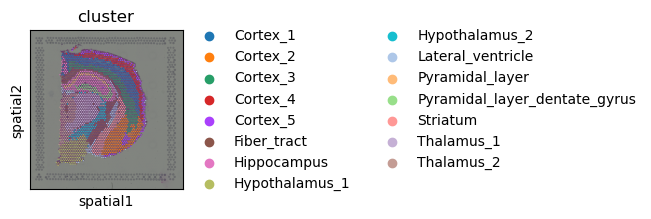

In [18]:
sq.pl.spatial_scatter(adata, color="cluster")

In [19]:
Y_sums = np.array(np.sum(adata.raw.X > 0, axis=0))[0]
Y = np.array(adata.raw.X[:, Y_sums>200].todense(), dtype=int).T
X = adata.obsm['spatial']

In [20]:
X = torch.tensor(X, dtype=torch.float)
Y = torch.tensor(Y, dtype=torch.float)
print(X.shape)
print(Y.shape)

torch.Size([2688, 2])
torch.Size([11925, 2688])


In [21]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [9]:
def train(model, optimizer, X, y, device, steps=200, E=20, **kwargs):
    losses = []

    means = []
    scales = []
    idxs = []

    for it in tqdm(range(steps)):

        optimizer.zero_grad()
        pY, qF, qU, pU = model.forward(X=X, E=E, **kwargs)
        print("Shape of y:", y.shape)
        print("Expected shape by model output:", pY.mean.shape)  # Assuming pY is a distribution


        logpY = pY.log_prob(y)

        ELBO = (logpY).mean(axis=0).sum()
        ELBO -= torch.sum(distributions.kl_divergence(qU, pU))

        loss = -ELBO
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        if (it%10)==0:
            means.append(torch.exp(qF.mean.detach().cpu()).numpy())
            scales.append(qF.scale.detach().cpu().numpy())

    with torch.no_grad():
        if device.type=='cuda':
            torch.cuda.empty_cache()

    return losses, means, scales

NUM INDUCING POINTS (M): 1000
NUM NEIGHBORS (K): 5
NUM GPS (L): 10
X_SHAPE: torch.Size([2688, 2])
Y_SHAPE: torch.Size([11925, 2688])


/var/folders/dv/w3pzlt_11hdcpw6gskd45b_80000gn/T/ipykernel_4765/1003330184.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp.Z = nn.Parameter(torch.tensor(X[idx]), requires_grad=True) # ADJUST


  0%|          | 0/10 [00:00<?, ?it/s]

Shape of y: torch.Size([11925, 2688])
Expected shape by model output: torch.Size([10, 11925, 2688])
Shape of y: torch.Size([11925, 2688])
Expected shape by model output: torch.Size([10, 11925, 2688])
Shape of y: torch.Size([11925, 2688])
Expected shape by model output: torch.Size([10, 11925, 2688])
Shape of y: torch.Size([11925, 2688])
Expected shape by model output: torch.Size([10, 11925, 2688])
Shape of y: torch.Size([11925, 2688])
Expected shape by model output: torch.Size([10, 11925, 2688])
Shape of y: torch.Size([11925, 2688])
Expected shape by model output: torch.Size([10, 11925, 2688])
Shape of y: torch.Size([11925, 2688])
Expected shape by model output: torch.Size([10, 11925, 2688])
Shape of y: torch.Size([11925, 2688])
Expected shape by model output: torch.Size([10, 11925, 2688])
Shape of y: torch.Size([11925, 2688])
Expected shape by model output: torch.Size([10, 11925, 2688])
Shape of y: torch.Size([11925, 2688])
Expected shape by model output: torch.Size([10, 11925, 2688])


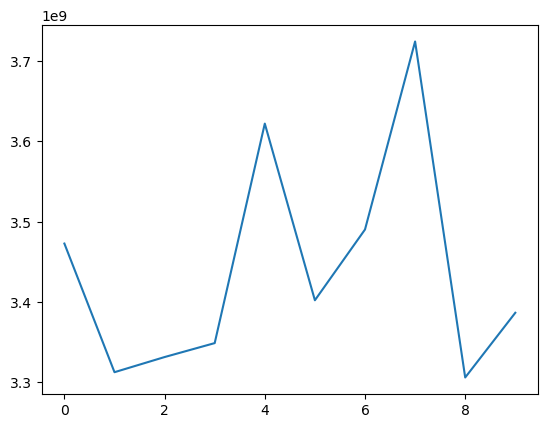

In [10]:
# initialize dictionary
L = 10
M = 1000

idx = torch.multinomial(torch.ones(X.shape[0]), num_samples=M, replacement=False)
kernel = NSF_RBF(L=L, sigma=1.0, lengthscale=5.0)
gp = VNNGP(kernel, M=M, jitter=1e-1, K=5)
gp.Lu = nn.Parameter(torch.eye(M).expand(L, M, M).clone())
gp.mu = nn.Parameter(torch.randn((L, M)))
gp.Z = nn.Parameter(torch.tensor(X[idx]), requires_grad=True) # ADJUST


model = NSF2(gp=gp, y=Y, L=L)
model.to(device)
X_train = X.to(device)
Y_train = Y.to(device)

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)

model.to(device)
start_time = time.time()
print(f'NUM INDUCING POINTS (M): {M}')
print(f'NUM NEIGHBORS (K): {5}')
print(f'NUM GPS (L): {L}')
print(f'X_SHAPE: {X.shape}')
print(f'Y_SHAPE: {Y.shape}')
losses, means, scales = train(model, optimizer, X_train, Y_train, device, steps=10, E=10)
end_time = time.time()
final_time = end_time - start_time

# save losses
fig1, ax1 = plt.subplots()
plt.plot(losses)
#fig1.savefig(f'{alg}_N={num_N[i]}_Z={M}_loss.png')
#plt.close(fig1)